In [17]:
#load data
import pandas as pd

features = pd.read_csv("/Users/nissani/Desktop/search_engine_project/data/features_train/features_resnet1000_train.csv")

In [18]:
features_array = table.values

In [19]:
image_names = []
image_features = []
for image in features_array:
    image_names.append(image[0])
    image_features.append(image[1:])

In [20]:
print(image_names)

['images_train/984.jpg', 'images_train/7127.jpg', 'images_train/9609.jpg', 'images_train/5293.jpg', 'images_train/3688.jpg', 'images_train/3340.jpg', 'images_train/4787.jpg', 'images_train/5707.jpg', 'images_train/1262.jpg', 'images_train/8355.jpg', 'images_train/6988.jpg', 'images_train/5428.jpg', 'images_train/7804.jpg', 'images_train/5741.jpg', 'images_train/9235.jpg', 'images_train/9492.jpg', 'images_train/85.jpg', 'images_train/5328.jpg', 'images_train/6011.jpg', 'images_train/9795.jpg', 'images_train/9632.jpg', 'images_train/8546.jpg', 'images_train/9375.jpg', 'images_train/3626.jpg', 'images_train/7420.jpg', 'images_train/9260.jpg', 'images_train/7918.jpg', 'images_train/8378.jpg', 'images_train/4825.jpg', 'images_train/1499.jpg', 'images_train/1947.jpg', 'images_train/5116.jpg', 'images_train/634.jpg', 'images_train/322.jpg', 'images_train/8743.jpg', 'images_train/3539.jpg', 'images_train/8944.jpg', 'images_train/5749.jpg', 'images_train/7368.jpg', 'images_train/6724.jpg', 'ima

In [21]:
print(image_features[:10])

[array([-1.3469539880752563, -3.1194605827331543, -0.7659709453582764,
       -1.38254976272583, -1.104675054550171, -3.65627121925354,
       -4.815435886383057, -0.5569421052932739, -1.4022855758666992,
       1.4268966913223269, -1.3979238271713257, -0.8171153664588928,
       -0.9556503295898438, -2.1374647617340092, -1.0306931734085083,
       -0.7944015264511108, -0.5622919797897339, -1.3677978515625,
       0.0970473438501358, -1.8191022872924805, -2.203221559524536,
       0.7060067057609558, -2.0152547359466557, 0.6819062232971191,
       -1.984688639640808, -1.772858738899231, -2.840861320495605,
       -2.7602927684783936, -2.11061692237854, -3.1680212020874023,
       -3.1652579307556152, -1.760022521018982, -1.8878074884414675,
       -2.6284496784210205, -0.8828712701797485, -1.1127841472625732,
       -0.4097294807434082, -2.694241762161255, -0.20765772461891172,
       0.33670759201049805, -0.483212560415268, -0.4793235659599304,
       -1.9848990440368648, -1.705091118

In [26]:
import csv

text_0 = []

with open('/Users/nissani/Desktop/search_engine_project/data/descriptions_train/0.txt', 'r') as f:
    reader = csv.reader(f, delimiter = ' ')
    for line in reader:
        text_0.append(line)

In [27]:
print(text_0)

[['The', 'skateboarder', 'is', 'putting', 'on', 'a', 'show', 'using', 'the', 'picnic', 'table', 'as', 'his', 'stage.'], ['A', 'skateboarder', 'pulling', 'tricks', 'on', 'top', 'of', 'a', 'picnic', 'table.'], ['A', 'man', 'riding', 'on', 'a', 'skateboard', 'on', 'top', 'of', 'a', 'table.'], ['A', 'skate', 'boarder', 'doing', 'a', 'trick', 'on', 'a', 'picnic', 'table.'], ['A', 'person', 'is', 'riding', 'a', 'skateboard', 'on', 'a', 'picnic', 'table', 'with', 'a', 'crowd', 'watching.']]


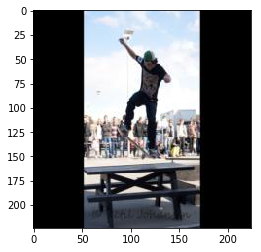

In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('/Users/nissani/Desktop/search_engine_project/data/images_train/0.jpg')
imgplot = plt.imshow(img)